In [ ]:
# Install necessary packages (for Colab)
!pip install neurodsp
!pip install bycycle

In [1]:
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from itertools import product
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_oscillation, sim_powerlaw
from bycycle import Bycycle

# Burst Detection

Burst detection is a difficult processes that requires tuning various thresholds. This is further complicated by the lack of ground truth labels (e.g. bursting or not) in real data. This notebook explore simulations of bursts using various waveform shapes. The `Bycycle` package implements two burst detection methods: 

1. "cycles" : uses ampltitude fraction, period & amplitdue consistency, and montonocity feature thresholds
2. "amp"    : use a dual threshold amplitude algorithm and a burst fraction threshold

The use of these methods is demonstrated below. Lastly, a sensitivity analysis is ran comparing the accuracy of the two methods.

## Simulation

A sine, asymmetrical since, triangle, and sawtooth waves are simulated as single bursts using the `neurodsp` package.

In [2]:
# Settings
n_seconds = 3
fs = 1000
n_samples = int(n_seconds * fs)
freq = 5

labels = ['Sine', 'Asymmetrical Sine', 'Triangle', 'Sawtooth']

cycles = [
    ('sine', {'phase': 'min'}),
    ('asine', {'rdsym': 0.1}),
    ('sawtooth', {'width': 0.5}),
    ('sawtooth', {'width': 0.1}),
]

# Simulate bursts
sigs = np.zeros((len(cycles), n_samples))

for i, cyc in enumerate(cycles):
    # Periodic / Burst
    sigs[i] = sim_oscillation(n_seconds, fs, freq, cycle=cyc[0], **cyc[1])

    # Zero pad burst
    sigs[i, :fs] = 0.
    sigs[i, -fs:] = 0.

    # Aperiodic
    np.random.seed(i)
    sigs[i] += sim_powerlaw(n_seconds, fs, exp=-2) * .8

## Bycycle

The "cycles" and "amp" methods are tested below. All threshold are for method="cycles" bounded between zero and one. Shaded colors on the plots represent which burst threshold is violated. Feel free to modifiy these parameters to get a sense of how they affect burst detection accuracy.

### `Bycycle(burst_method='cycles', ...)`

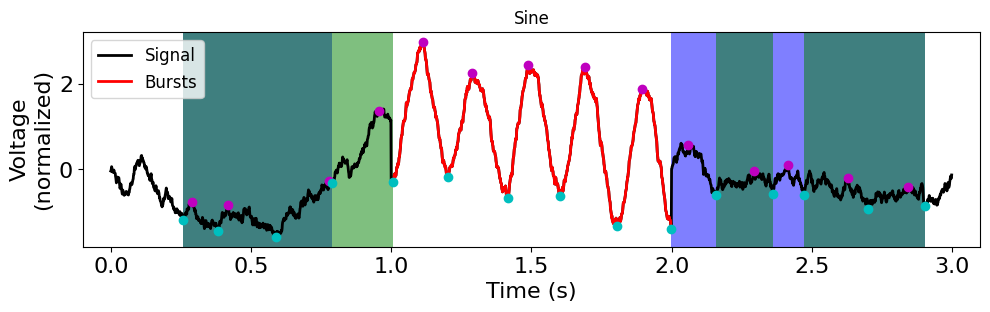

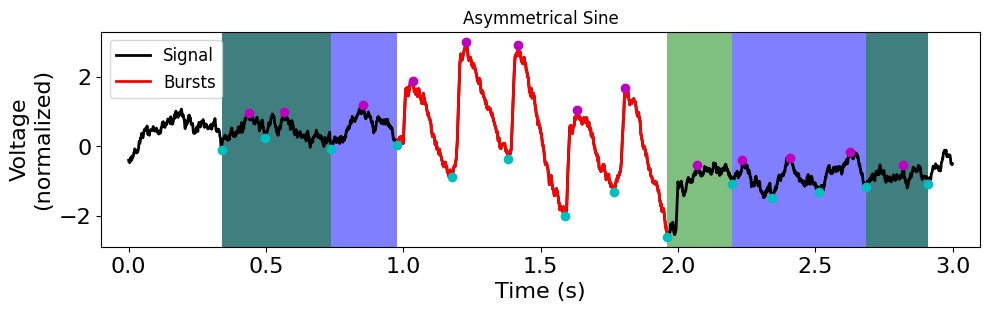

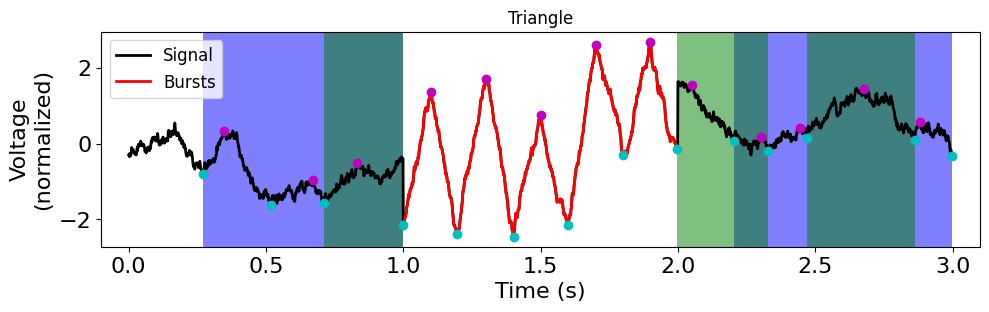

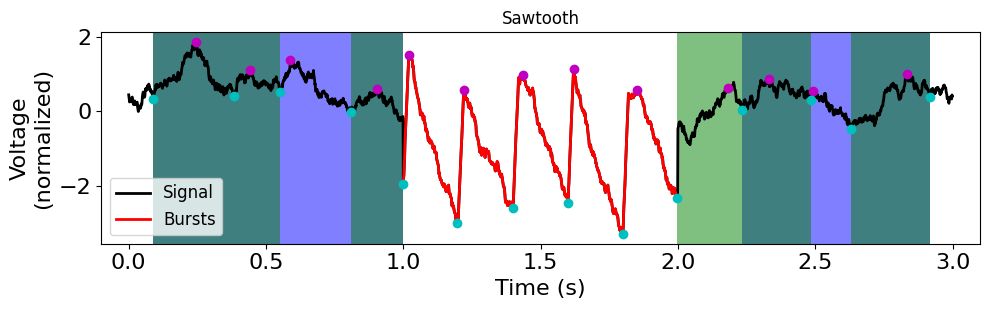

In [3]:
# Burst detection thresholds (change these)
burst_thresholds = {
    'amp_fraction': 0.6,
    'amp_consistency': 0.0,
    'period_consistency': 0.0,
    'monotonicity': 0.6
}

# Intialize model

bm = Bycycle(thresholds=burst_thresholds)

for i in range(len(sigs)):
    
    bm.fit(sigs[i], fs, (4, 6))
    bm.plot(plot_only_results=True, figsize=(10, 3))
    plt.title(labels[i])
    plt.xlim(-.1, 3.1)

### `Bycycle(burst_method='amp', ...)`

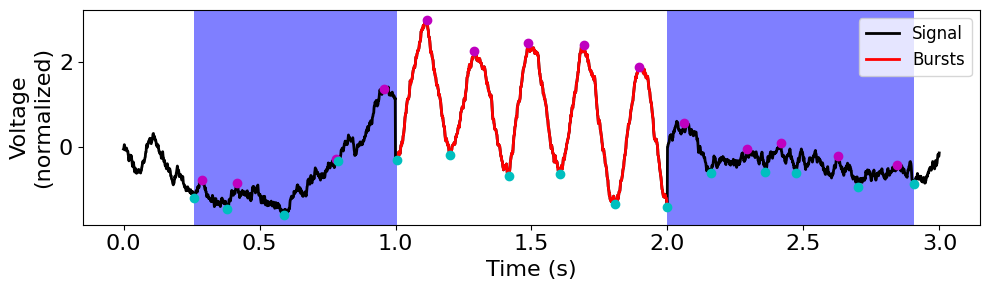

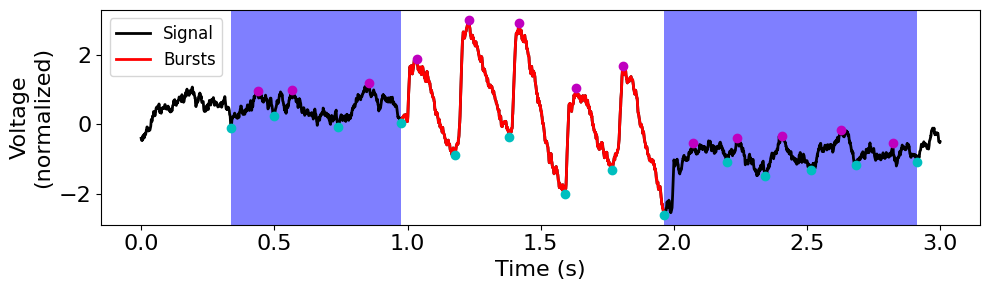

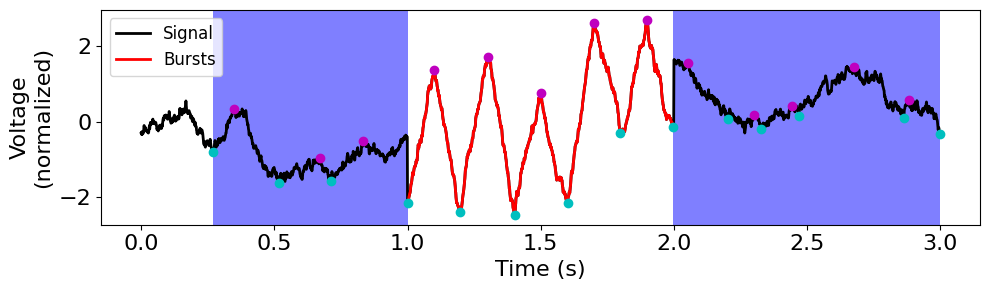

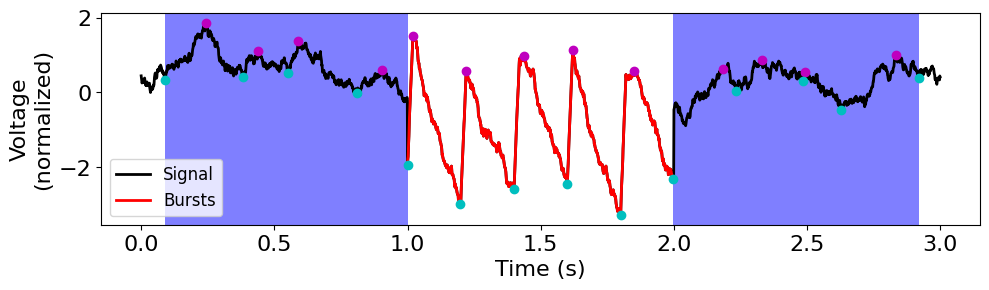

In [4]:
# Burst detection thresholds (change these)
amp_thresholds = (2, 2)

burst_thresholds = {'burst_fraction': 0.9}

# Intialize model
bm = Bycycle(burst_method='amp', thresholds=burst_thresholds,
             burst_kwargs={'amp_threshes': amp_thresholds})

time = np.arange(0, len(sigs[0])/fs, 1/fs)

for i in range(len(sigs)):
    
    bm.fit(sigs[i], fs, (4, 6))
    bm.plot(plot_only_results=True, figsize=(10, 3))
    #lt.title(labels[i])

## Sensitivity Analysis

Next, we systematically vary burst detection thresholds in a grid search. Results show that the "amp" method is more forgiving and requires less precise tuning.

In [5]:
def burst_accuracy(sigs, fs, params, param_names, burst_true, method):

    # Score
    accuracies = np.zeros(len(sigs))

    # Accuracy for each simulated signal
    for i in range(len(sigs)):

        if method == 'amp':
            
            # Amplitude thresholds
            amp_threshold = params[1]

            thresholds = {param_names[0]: params[0]}

            bm = Bycycle(burst_method='amp', thresholds=thresholds,
                         burst_kwargs={'amp_threshes': (amp_threshold, amp_threshold)})
            
        elif method == 'cycles':
    
            # Cycle thresholds
            thresholds = {
                'amp_fraction': 0.0,
                'amp_consistency': 0.0,
                'period_consistency': 0.0,
                'monotonicity': 0.0
            }

            for k, v in zip(param_names, params):
                thresholds[k] = v
            
            bm = Bycycle(thresholds=thresholds)

        # Run bycycle
        bm.fit(sigs[i], fs, (4, 6))

        # Predicted bursts
        burst_pred = np.zeros(len(sigs[0]), dtype=bool)
        columns = zip(bm.sample_last_trough, bm.sample_next_trough, bm.is_burst)
        
        for start, end, is_burst in columns:
            if is_burst:
                burst_pred[start:end] = True
    
        # Remove pre/post period
        burst_pred = burst_pred[fs//2:-fs//2]

        # Accuracy
        accuracies[i] = (burst_true == burst_pred).sum() / len(burst_true)

    return accuracies.mean() 

In [6]:
# Ground truth labels
burst_true = np.ones(len(sigs[0]), dtype=bool)
burst_true[:fs] = False
burst_true[-fs:] = False
burst_true = burst_true[fs//2:-fs//2]

In [7]:
# Create and run parameter grid for cycles method
param_names = ['amp_fraction', 'monotonicity']

acc_func = lambda params : burst_accuracy(sigs, fs, params, param_names, burst_true, 'cycles')

thresholds = np.linspace(0, 1, 11).round(2)

params = list(product(thresholds, thresholds))

accuracies_cycles = np.zeros(len(params))

for (i, param) in tqdm(enumerate(params), total=len(params)):
    accuracies_cycles[i] = acc_func(param)

  0%|          | 0/121 [00:00<?, ?it/s]

In [8]:
# Create and run parameter grid for amplitude method
param_names = ['burst_fraction', 'amp_threshold']

accuracy_func = lambda params : burst_accuracy(sigs, fs, params, param_names, burst_true, 'amp')

burst_fraction = np.linspace(0, 1, 11).round(2)
amp_threshold = np.linspace(.1, 3.1, 11).round(2)

params = list(product(burst_fraction, amp_threshold))

accuracies_amp = np.zeros(len(params))

for (i, param) in tqdm(enumerate(params), total=len(params)):
    accuracies_amp[i] = accuracy_func(param)

  0%|          | 0/121 [00:00<?, ?it/s]

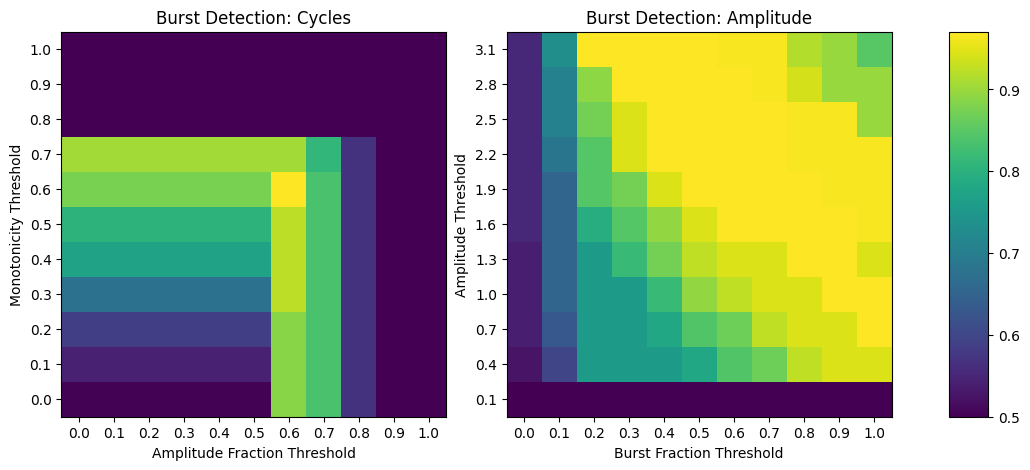

In [9]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), width_ratios=[1., 1., .1])

im = axes[0].imshow(accuracies_cycles.reshape(11, 11), origin='lower')
axes[0].set_xlabel('Amplitude Fraction Threshold')
axes[0].set_ylabel('Monotonicity Threshold')
axes[0].set_xticks(np.arange(11), labels=thresholds)
axes[0].set_yticks(np.arange(11), labels=thresholds);

im = axes[1].imshow(accuracies_amp.reshape(11, 11), origin='lower')
axes[1].set_xlabel('Burst Fraction Threshold')
axes[1].set_ylabel('Amplitude Threshold')
axes[1].set_xticks(np.arange(11), labels=burst_fraction)
axes[1].set_yticks(np.arange(11), labels=amp_threshold);

axes[0].set_title("Burst Detection: Cycles")
axes[1].set_title("Burst Detection: Amplitude")

fig.colorbar(im, cax=axes[2]);